In [1]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
import os
import pandas as pd

# Define the main folders and subfolders containing the CSV files
main_folders = ['Public Light', 'Public Full']
sub_folders = ['t-g-plot', 'delay-plot']

# Initialize dictionaries to hold DataFrames for each plot type
all_files = {'t-g-plot': [], 'delay-plot': []}

# Function to extract location and loop from filename
def extract_info_from_filename(filename):
    parts = filename.split('-')
    location = next((part for part in parts if 'loc' in part), 'unknown')
    loop = next((int(part[4:]) for part in parts if part.startswith('loop')), None)
    if loop is None:
        raise ValueError(f"Cannot extract loop number from filename: {filename}")
    return location, loop

# Iterate over each main folder
for main_folder in main_folders:
    # Determine traffic type based on the main folder
    traffic = 'Full' if 'Full' in main_folder else 'Light'
    
    # Iterate over each subfolder
    for sub_folder in sub_folders:
        folder_path = os.path.join(main_folder, sub_folder)
        
        # Get the list of all CSV files in the subfolder
        csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

        # Iterate over each CSV file
        for csv_file in csv_files:
            # Load the CSV file
            file_path = os.path.join(folder_path, csv_file)
            df = pd.read_csv(file_path)
            
            # Extract location and loop from filename
            location, loop = extract_info_from_filename(csv_file)
            network = 'public'
            
            # Add new columns
            df['loop'] = loop
            df['traffic'] = traffic
            df['network'] = network
            df['location'] = location
            
            # Reorder columns to place new columns before the first original column
            new_columns = ['loop', 'traffic', 'network', 'location']
            cols = new_columns + [col for col in df.columns if col not in new_columns]
            df = df[cols]
            
            # Append the DataFrame to the list for the corresponding plot type
            all_files[sub_folder].append(df)

# Merge all DataFrames for each plot type, sort, and save to separate CSV files
for plot_type, dataframes in all_files.items():
    merged_df = pd.concat(dataframes, ignore_index=True)
    # Sort by traffic and loop
    merged_df['traffic'] = pd.Categorical(merged_df['traffic'], categories=['Full', 'Light'], ordered=True)
    merged_df = merged_df.sort_values(by=['traffic', 'loop']).reset_index(drop=True)
    output_filename = f'merged-{plot_type}.csv'
    merged_df.to_csv(output_filename, index=False)

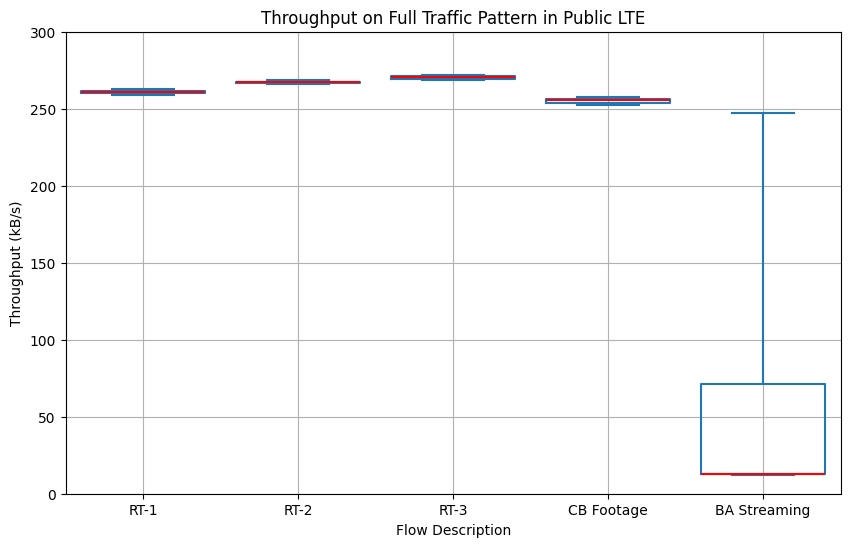

In [4]:
import matplotlib.pyplot as plt

# Load the CSV file
merged_df = pd.read_csv('public-t-g-plot.csv')

# Define flow descriptions
flow_descriptions = {
    1: 'RT-1',
    2: 'RT-2',
    3: 'RT-3',
    7: 'CB Footage',
    8: 'BA Streaming'
}

# Filter the data for flow IDs 1, 2, 3, 7, and 8
filtered_data = merged_df[merged_df['FlowID'].isin([1, 2, 3, 7, 8])].copy()

# Convert Throughput to kilobytes (KB/s)
filtered_data['Throughput'] = filtered_data['Throughput'] / 1000

# Create two figures, one for Full traffic and one for Light traffic
full_traffic_data = filtered_data[filtered_data['traffic'] == 'Full'].copy()
light_traffic_data = filtered_data[filtered_data['traffic'] == 'Light'].copy()

# Map Flow IDs to descriptions
full_traffic_data.loc[:, 'FlowDescription'] = full_traffic_data['FlowID'].map(flow_descriptions)
light_traffic_data.loc[:, 'FlowDescription'] = light_traffic_data['FlowID'].map(flow_descriptions)

# Create the plot for full traffic data
plt.figure(figsize=(10, 6))

plot =sns.boxplot(data=full_traffic_data, x='FlowDescription', y='Throughput', whis=(0, 100),medianprops={"color": "r"}, fill=False)
plot.set_xlabel('Flow Description')
plot.set_ylabel('Throughput (kB/s)')
plot.set_title('Throughput on Full Traffic Pattern in Public LTE')
# Optional: Set y-axis limit
plot.set_ylim(0, 300)
plt.grid(True) 

plot.tick_params(labelrotation=0)



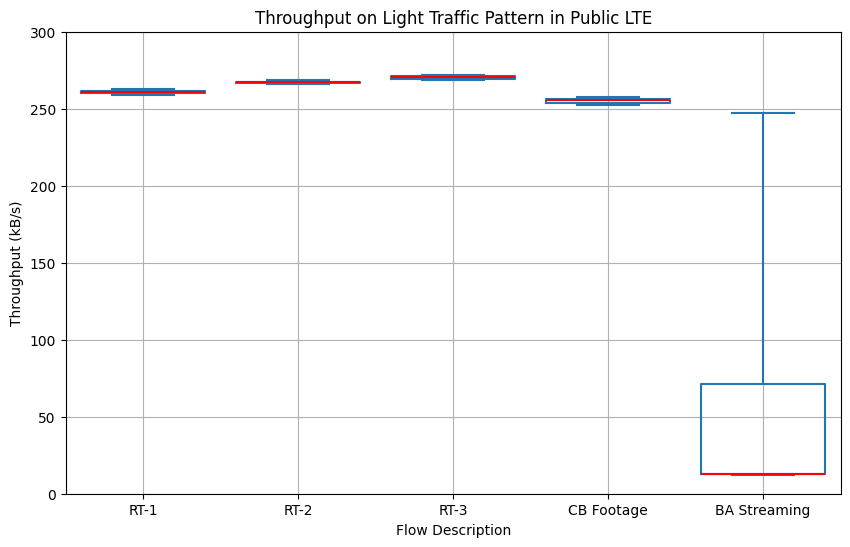

In [6]:
import matplotlib.pyplot as plt
# Create the plot for full traffic data
plt.figure(figsize=(10, 6))

plot = sns.boxplot(data=full_traffic_data, x='FlowDescription', y='Throughput', whis=(0, 100),medianprops={"color": "r"}, fill=False)


plot.set_xlabel('Flow Description')
plot.set_ylabel('Throughput (kB/s)')
plot.set_title('Throughput on Light Traffic Pattern in Public LTE')
# Optional: Set y-axis limit
plot.set_ylim(0, 300)
plt.grid(True) 


plot.tick_params(labelrotation=0)

Warehouse 

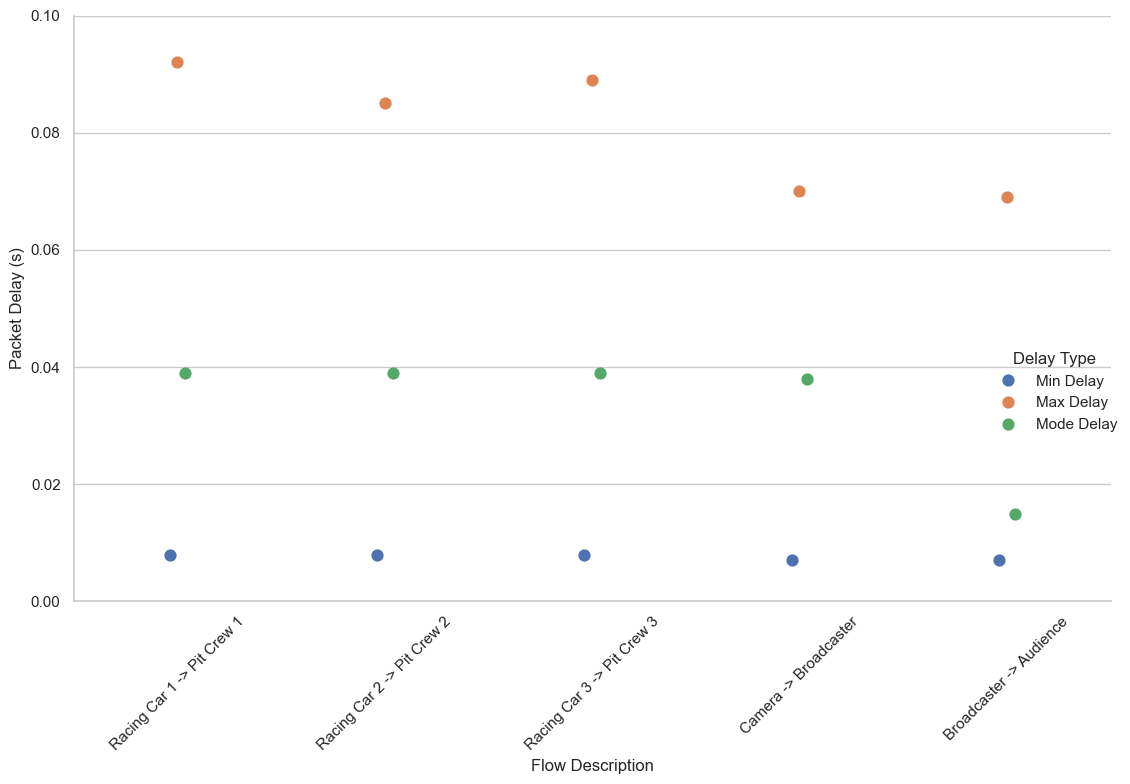

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the merged data
merged_df = pd.read_csv('public-delay-plot.csv')

# Define flow descriptions
flow_descriptions = {
    1: 'RT-1',
    2: 'RT-2',
    3: 'RT-3',
    7: 'CB Footage',
    8: 'BA Streaming'
}


# Filter the data based on FlowID
filtered_data = merged_df[merged_df['FlowID'].isin(flow_descriptions.keys())].copy()

# Map FlowID to Flow Description
filtered_data['Flow Description'] = filtered_data['FlowID'].map(flow_descriptions)

# Initialize a list to store the summary statistics
summary_stats = []

# Calculate min, max, and mode for each flow
for flow_id, flow_desc in flow_descriptions.items():
    flow_data = filtered_data[filtered_data['FlowID'] == flow_id]
    min_delay = flow_data['Start'].min()
    max_delay = flow_data['Start'].max()
    mode_delay = flow_data.loc[flow_data['Count'].idxmax(), 'Start']
    summary_stats.append({'Flow Description': flow_desc, 'Min Delay': min_delay, 'Max Delay': max_delay, 'Mode Delay': mode_delay})

# Convert summary statistics to DataFrame
summary_stats_df = pd.DataFrame(summary_stats)

# Prepare data for Seaborn plot
plot_data = []
for idx, row in summary_stats_df.iterrows():
    plot_data.append({'Flow Description': row['Flow Description'], 'Delay Type': 'Min Delay', 'Delay': row['Min Delay']})
    plot_data.append({'Flow Description': row['Flow Description'], 'Delay Type': 'Max Delay', 'Delay': row['Max Delay']})
    plot_data.append({'Flow Description': row['Flow Description'], 'Delay Type': 'Mode Delay', 'Delay': row['Mode Delay']})

plot_df = pd.DataFrame(plot_data)

# Create the Seaborn plot
sns.set(style="whitegrid")
plot = sns.catplot(x='Flow Description', y='Delay', hue='Delay Type', data=plot_df, kind='point', dodge=True, markers=['o', 'o', 'o'], linestyles=['', '', ''], height=8, aspect=1.25)

# Customize plot
plot.set_axis_labels('Flow Description', 'Packet Delay (s)')
plot.set_titles('Latency Distribution Pattern in Public LTE')
plot.set(ylim=(0, 0.1))  # Set the y-axis limit

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


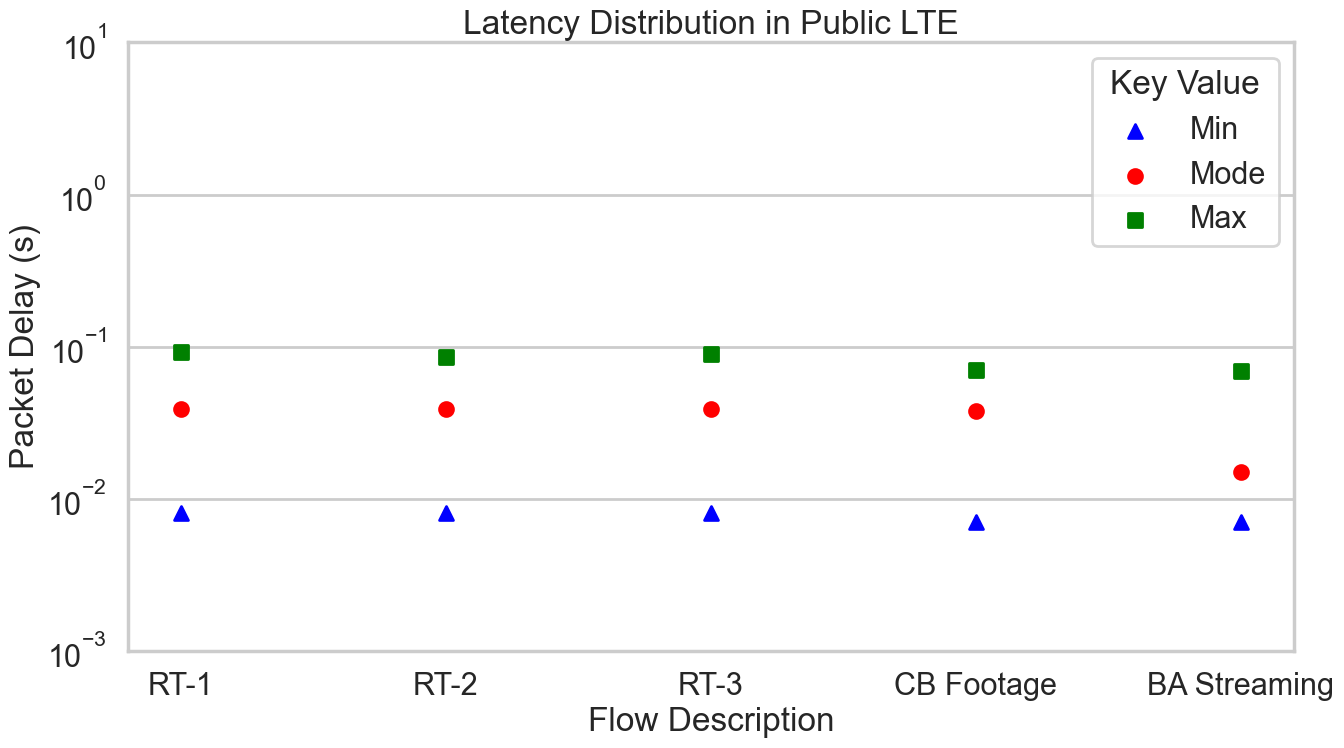

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the merged data
merged_df = pd.read_csv('public-delay-plot.csv')

# Define flow descriptions
flow_descriptions = {
    1: 'RT-1',
    2: 'RT-2',
    3: 'RT-3',
    7: 'CB Footage',
    8: 'BA Streaming'
}

# Filter the data based on FlowID
filtered_data = merged_df[merged_df['FlowID'].isin(flow_descriptions.keys())].copy()

# Map FlowID to Flow Description
filtered_data['Flow Description'] = filtered_data['FlowID'].map(flow_descriptions)

# Calculate min, max, and mode for each flow
stats_data = []
for flow_id, flow_desc in flow_descriptions.items():
    flow_data = filtered_data[filtered_data['FlowID'] == flow_id]
    
    min_delay = flow_data['Start'].min()
    max_delay = flow_data['Start'].max()
    
    # Calculate mode based on the highest count
    mode_delay = flow_data.loc[flow_data['Count'].idxmax(), 'Start']

    stats_data.append({
        'Flow Description': flow_desc,
        'Min': min_delay,
        'Max': max_delay,
        'Mode': mode_delay
    })

# Convert stats data to DataFrame
stats_df = pd.DataFrame(stats_data)

# Create the plot
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
sns.set_context('poster')

# Plot min, max, and mode
for idx, row in stats_df.iterrows():
    flow_desc = row['Flow Description']
    min_delay = row['Min']
    max_delay = row['Max']
    mode_delay = row['Mode']
    
    plt.scatter([flow_desc], [min_delay], color='blue', marker='^', s=100, label='Min' if idx == 0 else "")
    plt.scatter([flow_desc], [mode_delay], color='red', marker='o', s=100, label='Mode' if idx == 0 else "")
    plt.scatter([flow_desc], [max_delay], color='green', marker='s', s=100, label='Max' if idx == 0 else "")

# Customize plot
plt.xlabel('Flow Description')
plt.ylabel('Packet Delay (s)')
plt.ylim(1/1000, 10)  # Adjust the y-axis limit as needed
plt.yscale("log")
plt.title('Latency Distribution in Public LTE')
plt.xticks(rotation=0)
plt.grid(axis='x')
plt.legend(title='Key Value', loc='upper right')

# Show plot
plt.tight_layout()
#plt.show()
plt.savefig('abc.png',bbox_inches='tight')

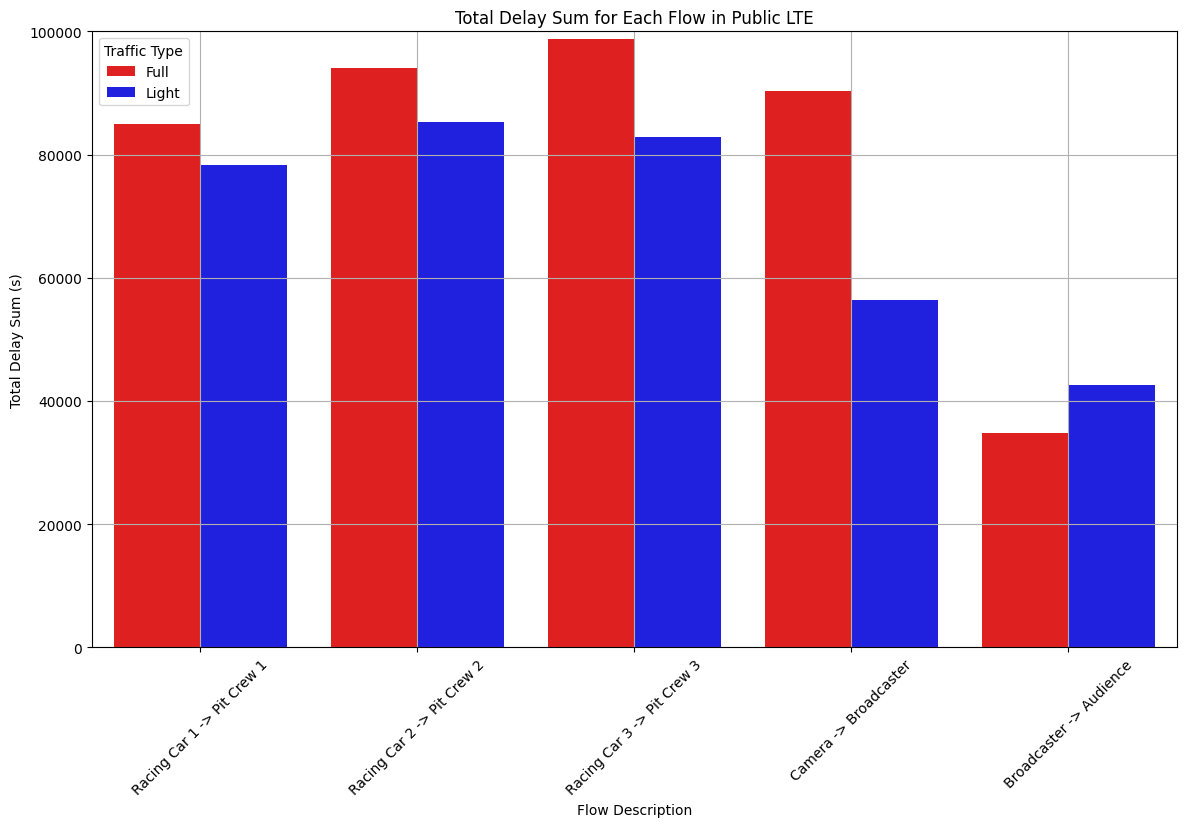

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the merged data
merged_df = pd.read_csv('public-delay-plot.csv')

# Define flow descriptions
flow_descriptions = {
    1: 'Racing Car 1 -> Pit Crew 1',
    2: 'Racing Car 2 -> Pit Crew 2',
    3: 'Racing Car 3 -> Pit Crew 3',
    7: 'Camera -> Broadcaster',
    8: 'Broadcaster -> Audience'
}

# Filter the data based on FlowID
filtered_data = merged_df[merged_df['FlowID'].isin([1, 2, 3, 7, 8])].copy()

# Calculate the delay sum for each FlowID
filtered_data['DelaySum'] = filtered_data['Start'] * filtered_data['Count']

# Aggregate the total delay sum for each FlowID and traffic type
delay_sums = filtered_data.groupby(['FlowID', 'traffic'])['DelaySum'].sum().reset_index()

# Map Flow IDs to descriptions
delay_sums['FlowDescription'] = delay_sums['FlowID'].map(flow_descriptions)

# Create the bar plot
plt.figure(figsize=(14, 8))
sns.barplot(data=delay_sums, x='FlowDescription', y='DelaySum', hue='traffic', palette={'Full': 'red', 'Light': 'blue'})

# Customize plot
plt.xlabel('Flow Description')
plt.ylabel('Total Delay Sum (s)')
plt.title('Total Delay Sum for Each Flow in Public LTE')
plt.legend(title='Traffic Type', loc='upper left')
plt.xticks(rotation=45)
plt.ylim(0, 100000)  # Set the Y-axis limits
plt.grid(True)

# Show plot
plt.show()


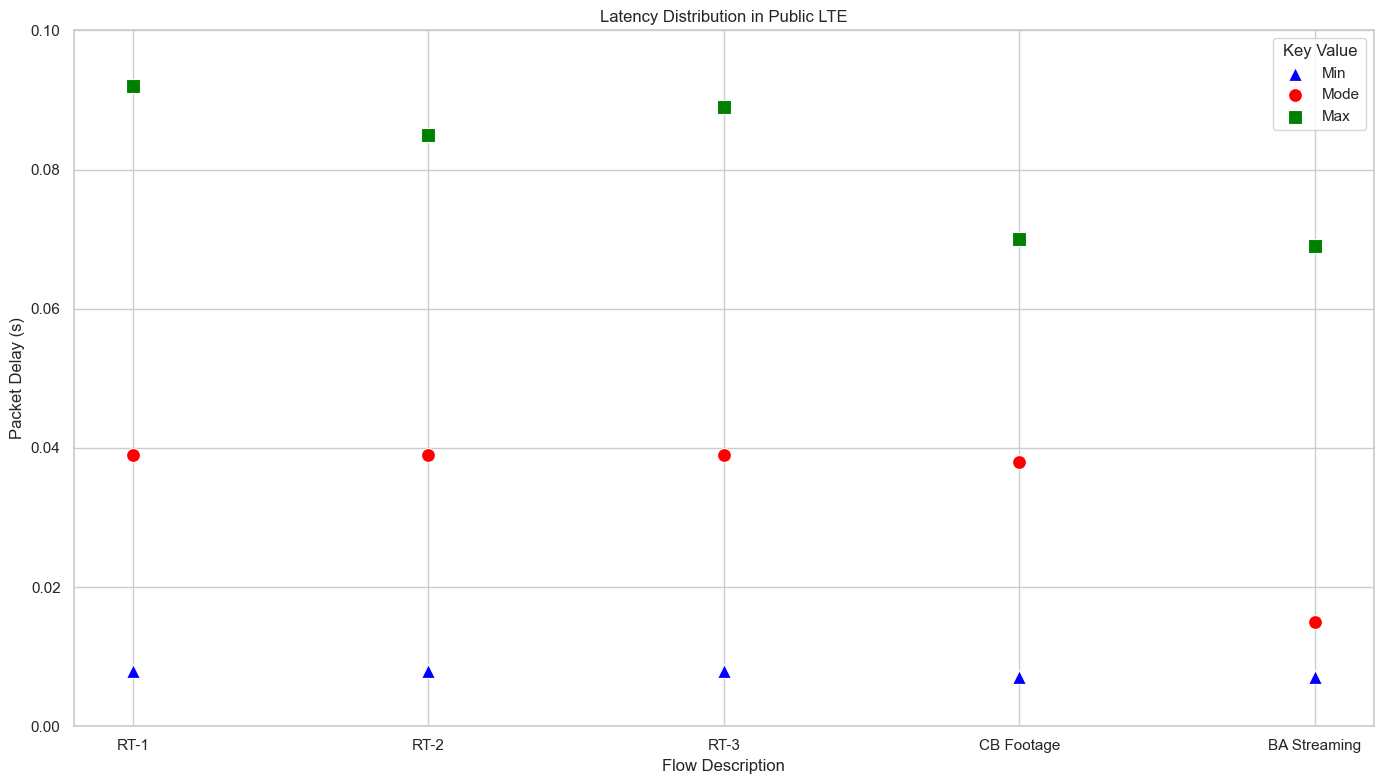

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the merged data
merged_df = pd.read_csv('public-delay-plot.csv')

# Define flow descriptions
flow_descriptions = {
    1: 'RT-1',
    2: 'RT-2',
    3: 'RT-3',
    7: 'CB Footage',
    8: 'BA Streaming'
}

# Filter the data based on FlowID
filtered_data = merged_df[merged_df['FlowID'].isin(flow_descriptions.keys())].copy()

# Map FlowID to Flow Description
filtered_data['Flow Description'] = filtered_data['FlowID'].map(flow_descriptions)

# Calculate min, max, and mode for each flow
stats_data = []
for flow_id, flow_desc in flow_descriptions.items():
    flow_data = filtered_data[filtered_data['FlowID'] == flow_id]
    
    min_delay = flow_data['Start'].min()
    max_delay = flow_data['Start'].max()
    
    # Calculate mode based on the highest count
    mode_delay = flow_data.loc[flow_data['Count'].idxmax(), 'Start']

    stats_data.append({
        'Flow Description': flow_desc,
        'Min': min_delay,
        'Max': max_delay,
        'Mode': mode_delay
    })

# Convert stats data to DataFrame
stats_df = pd.DataFrame(stats_data)

# Create the Seaborn scatter plot
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Plot min, max, and mode
for idx, row in stats_df.iterrows():
    flow_desc = row['Flow Description']
    min_delay = row['Min']
    max_delay = row['Max']
    mode_delay = row['Mode']
    
    sns.scatterplot(x=[flow_desc], y=[min_delay], color='blue', marker='^', s=100, label='Min' if idx == 0 else "")
    sns.scatterplot(x=[flow_desc], y=[mode_delay], color='red', marker='o', s=100, label='Mode' if idx == 0 else "")
    sns.scatterplot(x=[flow_desc], y=[max_delay], color='green', marker='s', s=100, label='Max' if idx == 0 else "")

# Customize plot
plt.xlabel('Flow Description')
plt.ylabel('Packet Delay (s)')
plt.ylim(0, 0.1)  # Adjust the y-axis limit as needed
plt.title('Latency Distribution in Public LTE')
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(title='Key Value', loc='upper right')

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
plt=sns.catplot(data=data[data['traffic'] == 'Light'], x='FlowID', y='Start', kind='strip', height=5, aspect=2)
plt.set(ylim=(0, 0.5))

In [ ]:
data = merged_df.copy()
data['FlowID'] 
data = data[data.FlowID.isin([1,2,3,7,8])]
data['Throughput'] = data['Throughput']/1000
plt = sns.catplot(data, x='FlowID', y='Throughput',kind='box',errorbar=('ci',100),)
plt.set(ylim=(0, 400))